In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from NST import NST

In [2]:
#implementation based on https://github.com/naoto0804/pytorch-AdaIN
class AdaIN(NST):
    def __init__(self, prebuild_encoder = None, prebuild_decoder = None):
        super().__init__(prebuild_encoder, prebuild_decoder)
        self.encoder = self._vgg()
        self.decoder = self._vggDecoder()

    def setup(self, encoderSlice = 31, decoderSlice = None):
        self.loadPrebuildEncoder(encoderSlice)
        self.loadPrebuildDecoder(decoderSlice)

    #Encoder by nato0804
    def _vgg(self):
        return nn.Sequential(
            nn.Conv2d(3, 3, (1, 1)),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(3, 64, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 64, (3, 3)),
            nn.ReLU(),  
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 128, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 128, (3, 3)),
            nn.ReLU(),  
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 256, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, (3, 3)),
            nn.ReLU(),  
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 512, (3, 3)),
            nn.ReLU(),  # relu4-1, this is the last layer used
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  
            nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(),  
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU(), 
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, (3, 3)),
            nn.ReLU()  
        )

    #Decoder by nato0804
    def _vggDecoder(self):
        return nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(512, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 3, 3),
        )

    #Adain implementation by nato0804
    #Calcualte mean and variance
    def __calc_mean_std(self, feat, eps=1e-5):
        N, C = feat.size()[:2]
        feat_ = feat.view(N, C, -1)
        mean = feat_.mean(dim=2).view(N, C, 1, 1)
        std = feat_.var(dim=2).add(eps).sqrt().view(N, C, 1, 1)
        return mean, std

    #Matching style with features 
    def __adain(self, content_feat, style_feat, alpha=1.0):
        c_mean, c_std = self.__calc_mean_std(content_feat)
        s_mean, s_std = self.__calc_mean_std(style_feat)
        normalized = (content_feat - c_mean) / c_std
        stylized = normalized * s_std + s_mean
        return alpha * stylized + (1 - alpha) * content_feat

        
    def stylisation(self, contentFeature, styleFeatures, alpha = 1.0):
        adaINOut = self.__adain(contentFeature, styleFeatures[0], alpha) #Handle 1 style currently
        return adaINOut

        
    def spatialControl(self, foreground_style_index = None, background_style_index = None):

        #Remove background and alpha
        self.content.removeBackground()
        self.content.extractAlpha()
        content = self.tensorisedContent
        styles = self.tensorisedStyles
        dimension = content.dim()

        #tensorise mask
        foreMask = torch.tensor(self.content.alphaOutput(), dtype=torch.float32)

        #Add dimension if insufficient
        while foreMask.dim() < content.dim():
            foreMask = foreMask.unsqueeze(0)
        
        #Mask for style and content
        foreStyle = (styles[foreground_style_index]) if foreground_style_index != None else None
        backStyle = (styles[background_style_index]) if background_style_index != None else None

        #Extract Features
        contentFeature = self.encoder(content)
        foreFeatureStyle = self.encoder(foreStyle) if foreground_style_index != None else None
        backFeatureStyle = self.encoder(backStyle) if background_style_index != None else None

        #Apply Adain
        styledForeground = self.stylisation(contentFeature, [foreFeatureStyle]) if foreFeatureStyle != None else contentFeature
        styledBackground = self.stylisation(contentFeature, [backFeatureStyle]) if backFeatureStyle != None else contentFeature

        #Resize mask
        d1,d2,h,w = contentFeature.shape
        foreMaskFeature = nn.functional.interpolate(foreMask, size=(h,w), mode="bilinear", align_corners=False)
        backMaskFeature = 1 - foreMaskFeature

        #Combine - prevent leak using masks
        combinedFeature = foreMaskFeature * styledForeground + backMaskFeature * styledBackground

        self.decoding(combinedFeature)


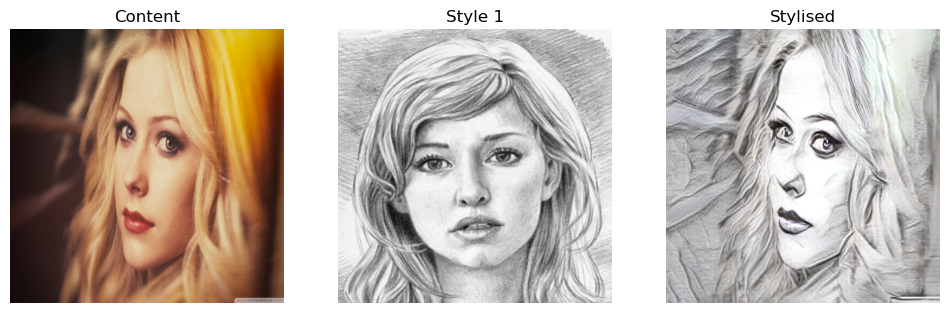

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


(0.708, '3763.665 ms')

In [3]:
style_path = "style/sketch.png"
prebuildEncoder = "vgg.pth"
prebuildDecoder = "decoder-adain.pth"
image_path = "content/avril.jpg"


adainModel = AdaIN(prebuildEncoder, prebuildDecoder)
adainModel.setup()
adainModel.fit(image_path, [style_path])
adainModel.pipeline(adainModel.stylisation)
adainModel.displayImages()
adainModel.evaluate()

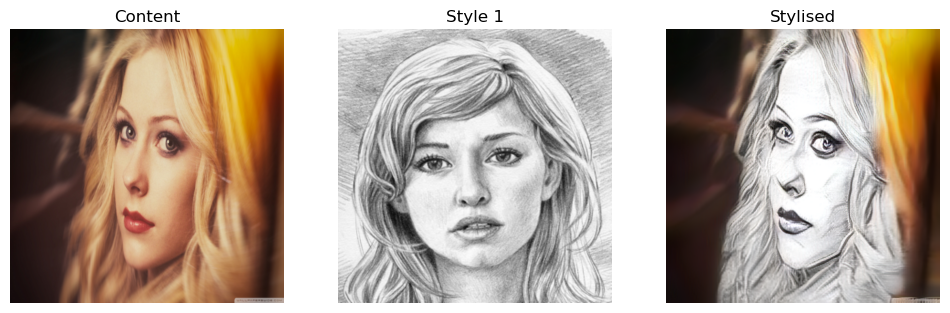

In [4]:
adainModel.spatialControl(0)
adainModel.displayImages()

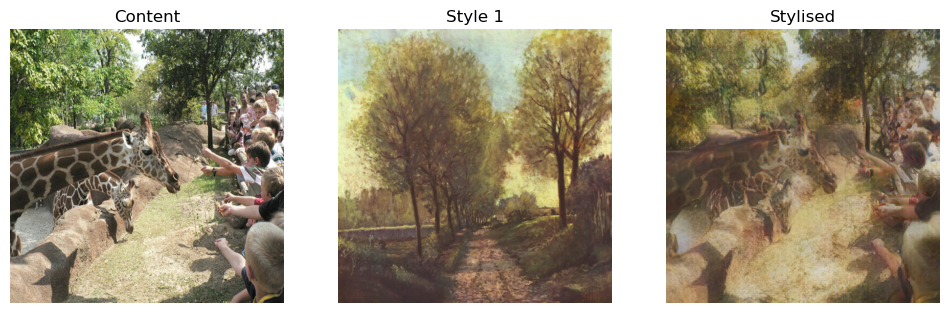

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
(0.436, '1411.460 ms')


In [5]:
def analysis(model,cNum,sNum, savedName = "AdaIN"):
    style = f"Test/Style/Style-{sNum}.jpg"
    content = f"Test/Content/Content-{cNum}.jpg"

    model.fit(content,[style])
    
    model.pipeline(model.stylisation)
    
    model.displayImages()

    model.saveImage(savedName)

    score = model.evaluate()
    print(score)
    return score

score1 = analysis(adainModel,1,1, "AdaIN-output-1")

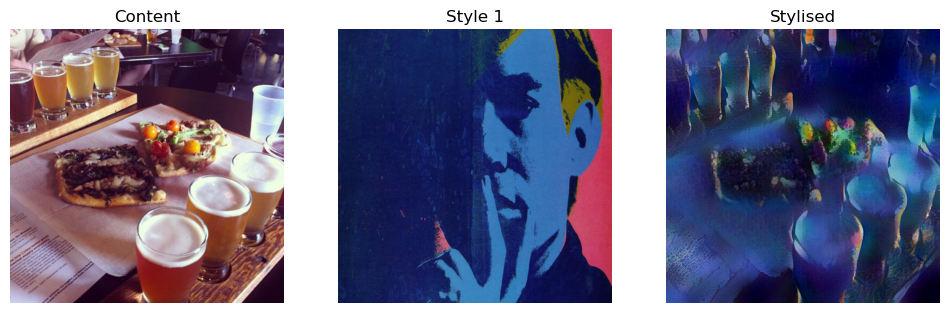

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
(0.613, '1386.955 ms')


In [6]:
score2 = analysis(adainModel,2,2, "AdaIN-output-2")

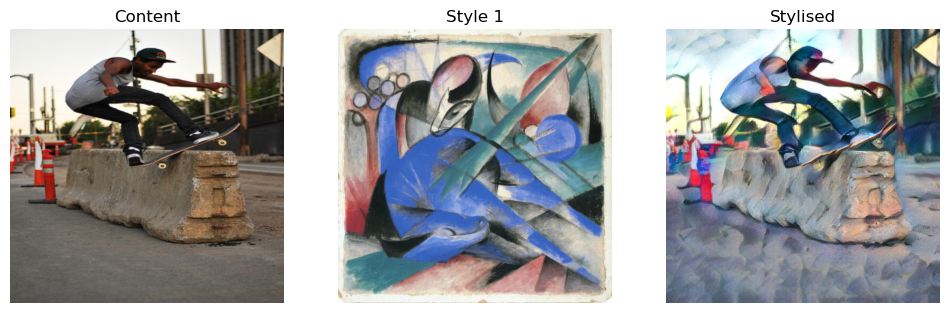

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
(0.442, '3450.923 ms')


In [7]:
score3 = analysis(adainModel,3,3, "AdaIN-output-3")

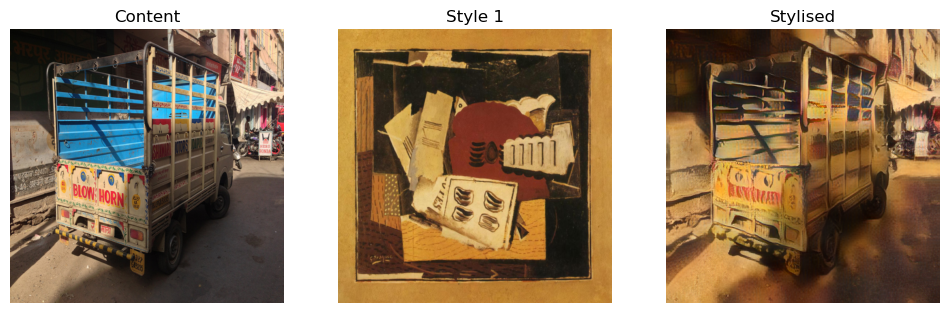

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
(0.375, '2118.522 ms')


In [8]:
score4 = analysis(adainModel,4,4, "AdaIN-output-4")

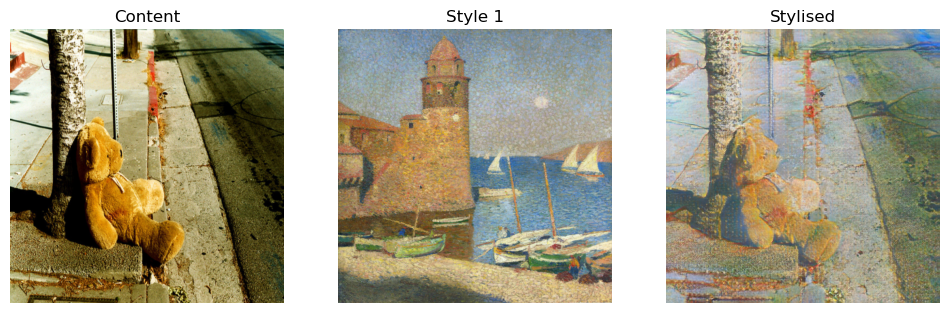

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
(0.46, '1547.737 ms')


In [9]:
score5 = analysis(adainModel,5,5, "AdaIN-output-5")

In [25]:
scores = [score1,score2,score3,score4,score5]

In [53]:
lpips_score = np.array([s for s,t in scores])
np.mean(lpips_score)

0.4652

In [57]:
time = np.array([float(t.replace(" ms", "")) for s,t in scores])
np.mean(time)

1983.1194000000003